In [13]:
# Python 3.12 / pandas (M->ME) compatible
# Cross-Asset ETF Momentum Scorecard Backtest
# Strategies: SIMPLE-LO / SIMPLE-LS / TECH-LO / TECH-LS / HYBRID-LO / HYBRID-LS

from __future__ import annotations

import warnings
from dataclasses import dataclass
from typing import Any, Final, Literal

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

try:
    import yfinance as yf
except ImportError as e:
    raise ImportError("Please install yfinance: pip install yfinance") from e

try:
    from scipy.stats import skew as sp_skew, kurtosis as sp_kurtosis
    HAS_SCIPY: Final[bool] = True
except Exception:
    HAS_SCIPY = False


Mode = Literal["SIMPLE", "TECH", "HYBRID"]
Style = Literal["LO", "LS"]


# =========================
# 0) Config
# =========================
@dataclass(frozen=True)
class BacktestConfig:
    tickers: list[str]
    start_date: str = "2008-01-01"
    end_date: str | None = None
    cost_one_way: float = 0.001          # 10bp
    vol_window_days: int = 63
    target_ann_vol: float = 0.10
    gross_cap: float = 1.50
    n_long: int = 6
    n_short: int = 6
    cash_return_monthly: float = 0.0     # 0% cash return
    # pandas month-end frequency alias (pandas>=2.2 uses "ME" for month-end)
    month_end_freq: str = "ME"


CONFIG = BacktestConfig(
    tickers=[
        "SPY", "IWM", "EFA", "EEM",
        "AGG", "TLT", "LQD", "HYG", "EMB",
        "GLD", "DBC",
        "VNQ",
    ],
    start_date="2015-01-01",
)


# =========================
# 1) Data fetch (yfinance)
# =========================
def fetch_yf_daily(tickers: list[str], start: str, end: str | None = None) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Fetch daily Close and Adj Close from yfinance.
    - Adj Close is used as a total return proxy (dividend+split adjusted) if available.
    Returns: (close, adj), both DataFrames indexed by date with columns as tickers.
    """
    df = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        auto_adjust=False,  # keep Adj Close available
        actions=True,
        progress=False,
        group_by="column",
    )

    if df.empty:
        raise RuntimeError("yfinance returned empty data. Check connectivity/tickers/date range.")

    if isinstance(df.columns, pd.MultiIndex):
        close = df["Close"].copy() if "Close" in df.columns.levels[0] else pd.DataFrame(index=df.index)
        adj = df["Adj Close"].copy() if "Adj Close" in df.columns.levels[0] else pd.DataFrame(index=df.index)
    else:
        # single ticker case
        close = df[["Close"]].rename(columns={"Close": tickers[0]})
        adj = df[["Adj Close"]].rename(columns={"Adj Close": tickers[0]})

    close = close.reindex(columns=tickers)
    adj = adj.reindex(columns=tickers)

    close = close.dropna(axis=1, how="all")
    adj = adj.dropna(axis=1, how="all")

    return close, adj


close_daily, adj_daily = fetch_yf_daily(CONFIG.tickers, CONFIG.start_date, CONFIG.end_date)

# Choose price series: Adj Close if present; else Close (per ticker)
price_daily = adj_daily.copy()
for t in close_daily.columns:
    if t not in price_daily.columns:
        price_daily[t] = close_daily[t]
price_daily = price_daily.sort_index().sort_index(axis=1)

tickers_used: list[str] = list(price_daily.columns)
if len(tickers_used) < 5:
    raise RuntimeError(f"Too few tickers with data. Got {len(tickers_used)}: {tickers_used}")

print(f"Tickers used ({len(tickers_used)}): {tickers_used}")
print(f"Daily date range: {price_daily.index.min().date()} .. {price_daily.index.max().date()}")


# =========================
# 2) Indicators
# =========================
def ema(s: pd.Series, span: int) -> pd.Series:
    return s.ewm(span=span, adjust=False).mean()


def compute_rsi(price: pd.Series, period: int = 14) -> pd.Series:
    """
    Wilder-style RSI using ewm(alpha=1/period).
    """
    delta = price.diff()
    gain = delta.clip(lower=0.0)
    loss = (-delta).clip(lower=0.0)

    avg_gain = gain.ewm(alpha=1 / period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1 / period, adjust=False).mean()

    rs = avg_gain / avg_loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi


@dataclass
class MonthlyPanel:
    px_m: pd.DataFrame
    ret_m: pd.DataFrame
    daily_ret: pd.DataFrame
    vol_m: pd.DataFrame
    price_over_200_m: pd.DataFrame
    ma_cross_m: pd.DataFrame
    macd_hist_m: pd.DataFrame
    rsi14_m: pd.DataFrame


def compute_monthly_panel(price_daily: pd.DataFrame, vol_window_days: int, month_end_freq: str) -> MonthlyPanel:
    daily_ret = price_daily.pct_change()

    # month-end trading day prices (pandas>=2.2: use "ME" not "M")
    px_m = price_daily.resample(month_end_freq).last()
    ret_m = px_m.pct_change()

    # vol63 annualized at month-end
    vol_daily = daily_ret.rolling(vol_window_days).std() * np.sqrt(252)
    vol_m = vol_daily.reindex(px_m.index, method="ffill")

    # MA-based features
    ma200 = price_daily.rolling(200).mean()
    ma50 = price_daily.rolling(50).mean()

    price_over_200_m = (price_daily / ma200).reindex(px_m.index, method="ffill")
    ma_cross_m = (ma50 - ma200).reindex(px_m.index, method="ffill")

    # MACD hist & RSI at month-end
    macd_hist_m = pd.DataFrame(index=px_m.index, columns=price_daily.columns, dtype=float)
    rsi14_m = pd.DataFrame(index=px_m.index, columns=price_daily.columns, dtype=float)

    for col in price_daily.columns:
        p = price_daily[col].dropna()
        if p.empty:
            continue
        macd_line = ema(p, 12) - ema(p, 26)
        signal = ema(macd_line, 9)
        hist = macd_line - signal
        macd_hist_m[col] = hist.reindex(px_m.index, method="ffill")

        rsi14 = compute_rsi(p, 14)
        rsi14_m[col] = rsi14.reindex(px_m.index, method="ffill")

    return MonthlyPanel(
        px_m=px_m,
        ret_m=ret_m,
        daily_ret=daily_ret,
        vol_m=vol_m,
        price_over_200_m=price_over_200_m,
        ma_cross_m=ma_cross_m,
        macd_hist_m=macd_hist_m,
        rsi14_m=rsi14_m,
    )


panel = compute_monthly_panel(price_daily, CONFIG.vol_window_days, CONFIG.month_end_freq)


# =========================
# 3) Signals / Scorecard
# =========================
def compute_return_lookback(px_m: pd.DataFrame, months: int) -> pd.DataFrame:
    return px_m.pct_change(months)


def build_signals(
    mode: Mode,
    px_m: pd.DataFrame,
    vol_m: pd.DataFrame,
    price_over_200_m: pd.DataFrame,
    ma_cross_m: pd.DataFrame,
    macd_hist_m: pd.DataFrame,
    rsi14_m: pd.DataFrame,
) -> dict[str, pd.DataFrame]:
    """
    Signals are monthly and must follow: higher is better (rank descending).
    """
    ret_1m = compute_return_lookback(px_m, 1)
    ret_3m = compute_return_lookback(px_m, 3)
    ret_6m = compute_return_lookback(px_m, 6)
    ret_12m = compute_return_lookback(px_m, 12)

    rvol_6m = ret_6m / vol_m.replace(0, np.nan)
    rvol_12m = ret_12m / vol_m.replace(0, np.nan)

    simple: dict[str, pd.DataFrame] = {
        "Ret_3M": ret_3m,
        "Ret_6M": ret_6m,
        "Ret_12M": ret_12m,
        "Ret_12M_minus_1M": (ret_12m - ret_1m),
        "RVol_6M": rvol_6m,
        "RVol_12M": rvol_12m,
        "Price_over_200DMA": price_over_200_m,
        "MA_Cross_50_200": ma_cross_m,
    }

    if mode == "SIMPLE":
        return simple

    if mode == "TECH":
        tech = dict(simple)
        tech.pop("Ret_12M_minus_1M", None)
        tech.pop("MA_Cross_50_200", None)
        tech["MACD_Hist"] = macd_hist_m
        tech["RSI14"] = rsi14_m
        return tech

    hybrid = dict(simple)
    hybrid["MACD_Hist"] = macd_hist_m
    hybrid["RSI14"] = rsi14_m
    return hybrid


def score_from_signals(signals: dict[str, pd.DataFrame]) -> pd.DataFrame:
    ranks: list[pd.DataFrame] = []
    for s in signals.values():
        ranks.append(s.rank(axis=1, method="average", ascending=False))
    score = pd.concat(ranks, axis=0).groupby(level=0).mean()
    return score


# =========================
# 4) Portfolio + Backtest
# =========================
def estimate_portfolio_ann_vol(daily_ret_window: pd.DataFrame, w: pd.Series) -> float:
    cols = [c for c in w.index if c in daily_ret_window.columns]
    sub = daily_ret_window[cols].dropna(how="all")
    w_sub = w[cols].fillna(0.0)

    if sub.shape[0] < 10:
        port_daily = (sub.fillna(0.0) * w_sub.values).sum(axis=1)
        std = float(port_daily.std())
        return float(std * np.sqrt(252)) if std > 0 else np.nan

    cov = sub.cov()
    cov = cov.reindex(index=w_sub.index, columns=w_sub.index).fillna(0.0)
    port_var_daily = float(w_sub.values @ cov.values @ w_sub.values)
    if port_var_daily <= 0 or np.isnan(port_var_daily):
        return np.nan
    return float(np.sqrt(port_var_daily) * np.sqrt(252))


def build_weights(score_row: pd.Series, vol_row: pd.Series, style: Style, n_long: int, n_short: int) -> pd.Series:
    tickers = score_row.index
    w = pd.Series(0.0, index=tickers)

    valid = tickers[score_row.notna() & vol_row.notna() & (vol_row > 0)]
    if len(valid) == 0:
        return w

    s = score_row[valid].sort_values()  # lower is better
    vol = vol_row[valid]

    if style == "LO":
        chosen = s.index[: min(n_long, len(s))]
        inv = (1.0 / vol[chosen]).replace([np.inf, -np.inf], np.nan).dropna()
        if inv.empty:
            return w
        w.loc[inv.index] = inv / inv.sum()
        return w

    chosen_long = s.index[: min(n_long, len(s))]
    chosen_short = s.index[-min(n_short, len(s)) :]

    invL = (1.0 / vol[chosen_long]).replace([np.inf, -np.inf], np.nan).dropna()
    invS = (1.0 / vol[chosen_short]).replace([np.inf, -np.inf], np.nan).dropna()
    if invL.empty or invS.empty:
        return w

    w.loc[invL.index] = +invL / invL.sum()
    w.loc[invS.index] = -invS / invS.sum()
    return w


@dataclass
class BacktestResult:
    mode: Mode
    style: Style
    returns_gross: pd.Series
    returns_net: pd.Series
    weights: pd.DataFrame
    diag: pd.DataFrame
    score: pd.DataFrame


def run_backtest(config: BacktestConfig, panel: MonthlyPanel, mode: Mode, style: Style) -> BacktestResult:
    signals = build_signals(
        mode=mode,
        px_m=panel.px_m,
        vol_m=panel.vol_m,
        price_over_200_m=panel.price_over_200_m,
        ma_cross_m=panel.ma_cross_m,
        macd_hist_m=panel.macd_hist_m,
        rsi14_m=panel.rsi14_m,
    )
    score = score_from_signals(signals)

    dates = panel.px_m.index
    tickers = list(panel.px_m.columns)

    w_prev = pd.Series(0.0, index=tickers)
    weights_hist: dict[pd.Timestamp, pd.Series] = {}
    turnover_hist: dict[pd.Timestamp, float] = {}
    gross_hist: dict[pd.Timestamp, float] = {}
    net_hist: dict[pd.Timestamp, float] = {}

    r_gross: list[float] = []
    r_net: list[float] = []
    out_dates: list[pd.Timestamp] = []

    daily_idx = panel.daily_ret.index

    for t_idx in range(len(dates) - 1):
        t = dates[t_idx]
        t_next = dates[t_idx + 1]

        score_row = score.loc[t] if t in score.index else pd.Series(np.nan, index=tickers)
        vol_row = panel.vol_m.loc[t] if t in panel.vol_m.index else pd.Series(np.nan, index=tickers)

        w0 = build_weights(score_row, vol_row, style, config.n_long, config.n_short)

        eligible = daily_idx[daily_idx <= t]
        if len(eligible) == 0:
            w = w0.copy()
        else:
            end_date = eligible[-1]
            end_pos = daily_idx.get_loc(end_date)
            start_pos = max(0, end_pos - (config.vol_window_days - 1))
            window = panel.daily_ret.iloc[start_pos : end_pos + 1]

            est_vol = estimate_portfolio_ann_vol(window, w0)
            scale = (config.target_ann_vol / est_vol) if (est_vol is not None and np.isfinite(est_vol) and est_vol > 0) else 0.0
            w = w0 * scale

        gross = float(np.abs(w).sum())
        if gross > config.gross_cap and gross > 0:
            w = w * (config.gross_cap / gross)
            gross = float(np.abs(w).sum())

        net = float(w.sum())
        cash_w = (1.0 - net) if style == "LO" else (-net)

        r_next = panel.ret_m.loc[t_next].reindex(tickers)
        gross_ret = float((w * r_next).sum() + cash_w * config.cash_return_monthly)

        turnover = float(np.abs(w - w_prev).sum())
        cost = config.cost_one_way * turnover
        net_ret = gross_ret - cost

        weights_hist[t] = w
        turnover_hist[t] = turnover
        gross_hist[t] = gross
        net_hist[t] = net

        r_gross.append(gross_ret)
        r_net.append(net_ret)
        out_dates.append(t_next)

        w_prev = w

    returns_gross = pd.Series(r_gross, index=out_dates, name="gross_return")
    returns_net = pd.Series(r_net, index=out_dates, name="net_return")

    weights_df = pd.DataFrame(weights_hist).T
    weights_df.index.name = "rebalance_date"
    weights_df = weights_df.reindex(sorted(weights_df.columns), axis=1)

    diag = pd.DataFrame(
        {
            "turnover": pd.Series(turnover_hist),
            "gross_exposure": pd.Series(gross_hist),
            "net_exposure": pd.Series(net_hist),
        }
    )
    diag.index.name = "rebalance_date"

    return BacktestResult(
        mode=mode,
        style=style,
        returns_gross=returns_gross,
        returns_net=returns_net,
        weights=weights_df,
        diag=diag,
        score=score,
    )


# =========================
# 5) Metrics
# =========================
def max_drawdown(equity_curve: pd.Series) -> float:
    peak = equity_curve.cummax()
    dd = equity_curve / peak - 1.0
    return float(dd.min())


def summarize_returns(r: pd.Series, name: str) -> dict[str, Any]:
    r = r.dropna()
    if r.empty:
        return {"Strategy": name}

    n = int(r.shape[0])
    ann_factor = 12.0
    mean_m = float(r.mean())
    vol_m = float(r.std(ddof=1))

    total_growth = float((1 + r).prod())
    cagr = float(total_growth ** (ann_factor / n) - 1) if total_growth > 0 else np.nan
    ann_vol = float(vol_m * np.sqrt(ann_factor)) if vol_m > 0 else np.nan
    sharpe = float((mean_m / vol_m) * np.sqrt(ann_factor)) if vol_m > 0 else np.nan

    eq = (1 + r).cumprod()
    mdd = max_drawdown(eq)

    if HAS_SCIPY:
        sk = float(sp_skew(r.to_numpy(), bias=False))
        ku = float(sp_kurtosis(r.to_numpy(), fisher=True, bias=False))
    else:
        sk = float(r.skew())
        ku = float(r.kurtosis())

    var5 = float(np.quantile(r.to_numpy(), 0.05))
    cvar5 = float(r[r <= var5].mean()) if (r <= var5).any() else np.nan

    return {
        "Strategy": name,
        "CAGR": cagr,
        "AnnVol": ann_vol,
        "Sharpe": sharpe,
        "MaxDD": mdd,
        "Skew": sk,
        "Kurtosis": ku,
        "VaR_5%_M": var5,
        "CVaR_5%_M": cvar5,
        "Months": n,
    }


# =========================
# 6) Run all 6
# =========================
def run_all(config: BacktestConfig, panel: MonthlyPanel) -> tuple[dict[str, BacktestResult], pd.DataFrame]:
    configs: list[tuple[Mode, Style, str]] = [
        ("SIMPLE", "LO", "SIMPLE-LO"),
        ("SIMPLE", "LS", "SIMPLE-LS"),
        ("TECH", "LO", "TECH-LO"),
        ("TECH", "LS", "TECH-LS"),
        ("HYBRID", "LO", "HYBRID-LO"),
        ("HYBRID", "LS", "HYBRID-LS"),
    ]

    results: dict[str, BacktestResult] = {}
    rows: list[dict[str, Any]] = []

    for mode, style, name in configs:
        res = run_backtest(config, panel, mode, style)
        results[name] = res
        rows.append(summarize_returns(res.returns_net, name))

    metrics_df = pd.DataFrame(rows).set_index("Strategy").sort_index()
    return results, metrics_df

# ===== Equal-Weight Benchmark (EW-LO) =====

def run_equal_weight_lo_benchmark(config: BacktestConfig, panel: MonthlyPanel, name: str = "EW-LO") -> BacktestResult:
    """
    Benchmark: Equal-weight across all available tickers, monthly rebalance.
    - Gross exposure fixed at 1.0 (no leverage, no vol targeting).
    - Cash weight = 0 (fully invested).
    - Cost: one-way 10bp applied to turnover at each rebalance.
    """
    dates = panel.px_m.index
    tickers = list(panel.px_m.columns)

    w_prev = pd.Series(0.0, index=tickers)
    weights_hist: dict[pd.Timestamp, pd.Series] = {}
    turnover_hist: dict[pd.Timestamp, float] = {}
    gross_hist: dict[pd.Timestamp, float] = {}
    net_hist: dict[pd.Timestamp, float] = {}

    r_gross: list[float] = []
    r_net: list[float] = []
    out_dates: list[pd.Timestamp] = []

    for t_idx in range(len(dates) - 1):
        t = dates[t_idx]
        t_next = dates[t_idx + 1]

        # available tickers at t: need price at t and t_next (for return), otherwise exclude
        avail = panel.px_m.loc[t].notna() & panel.px_m.loc[t_next].notna()
        avail_tickers = list(panel.px_m.columns[avail])

        w = pd.Series(0.0, index=tickers)
        if len(avail_tickers) > 0:
            w.loc[avail_tickers] = 1.0 / len(avail_tickers)

        gross = float(np.abs(w).sum())     # should be 1.0 if any available
        net = float(w.sum())               # should be 1.0 if any available

        # fully invested: cash 0
        cash_w = 0.0

        r_next = panel.ret_m.loc[t_next].reindex(tickers).fillna(0.0)
        gross_ret = float((w * r_next).sum() + cash_w * config.cash_return_monthly)

        turnover = float(np.abs(w - w_prev).sum())
        cost = config.cost_one_way * turnover
        net_ret = gross_ret - cost

        weights_hist[t] = w
        turnover_hist[t] = turnover
        gross_hist[t] = gross
        net_hist[t] = net

        r_gross.append(gross_ret)
        r_net.append(net_ret)
        out_dates.append(t_next)

        w_prev = w

    returns_gross = pd.Series(r_gross, index=out_dates, name="gross_return")
    returns_net = pd.Series(r_net, index=out_dates, name="net_return")

    weights_df = pd.DataFrame(weights_hist).T
    weights_df.index.name = "rebalance_date"
    weights_df = weights_df.reindex(sorted(weights_df.columns), axis=1)

    diag = pd.DataFrame(
        {
            "turnover": pd.Series(turnover_hist),
            "gross_exposure": pd.Series(gross_hist),
            "net_exposure": pd.Series(net_hist),
        }
    )
    diag.index.name = "rebalance_date"

    # mode/style are placeholders to reuse BacktestResult structure
    return BacktestResult(
        mode="SIMPLE",  # dummy
        style="LO",     # dummy
        returns_gross=returns_gross,
        returns_net=returns_net,
        weights=weights_df,
        diag=diag,
        score=pd.DataFrame(index=panel.px_m.index, columns=panel.px_m.columns, dtype=float),  # dummy
    )


# ===== Replace run_all with benchmark included =====
def run_all(config: BacktestConfig, panel: MonthlyPanel) -> tuple[dict[str, BacktestResult], pd.DataFrame]:
    configs: list[tuple[Mode, Style, str]] = [
        ("SIMPLE", "LO", "SIMPLE-LO"),
        ("SIMPLE", "LS", "SIMPLE-LS"),
        ("TECH", "LO", "TECH-LO"),
        ("TECH", "LS", "TECH-LS"),
        ("HYBRID", "LO", "HYBRID-LO"),
        ("HYBRID", "LS", "HYBRID-LS"),
    ]

    results: dict[str, BacktestResult] = {}
    rows: list[dict[str, Any]] = []

    # 6 strategies
    for mode, style, name in configs:
        res = run_backtest(config, panel, mode, style)
        results[name] = res
        rows.append(summarize_returns(res.returns_net, name))

    # Equal-weight benchmark
    ew = run_equal_weight_lo_benchmark(config, panel, name="EW-LO")
    results["EW-LO"] = ew
    rows.append(summarize_returns(ew.returns_net, "EW-LO"))

    metrics_df = pd.DataFrame(rows).set_index("Strategy").sort_index()
    return results, metrics_df


# re-run
results, metrics_df = run_all(CONFIG, panel)
metrics_df

Tickers used (12): ['AGG', 'DBC', 'EEM', 'EFA', 'EMB', 'GLD', 'HYG', 'IWM', 'LQD', 'SPY', 'TLT', 'VNQ']
Daily date range: 2015-01-02 .. 2026-02-06


,CAGR,AnnVol,Sharpe,MaxDD,Skew,Kurtosis,VaR_5%_M,CVaR_5%_M,Months
Strategy,,,,,,,,,
EW-LO,0.062433,0.094718,0.688253,-0.198376,-0.512238,1.871639,-0.037121,-0.058576,133
HYBRID-LO,0.067511,0.092212,0.756330,-0.161809,-0.481485,0.610105,-0.042333,-0.056819,133
HYBRID-LS,0.008228,0.049733,0.189280,-0.117831,0.960750,4.238900,-0.019929,-0.026544,133
SIMPLE-LO,0.079884,0.093734,0.869147,-0.152853,-0.433661,0.542307,-0.041055,-0.055327,133
SIMPLE-LS,0.019981,0.050685,0.415634,-0.134127,0.556606,3.085203,-0.021068,-0.027889,133
TECH-LO,0.069023,0.091793,0.774917,-0.151784,-0.547817,0.847331,-0.040497,-0.057289,133
TECH-LS,0.008229,0.050093,0.188191,-0.116182,1.373172,6.868532,-0.019354,-0.025246,133


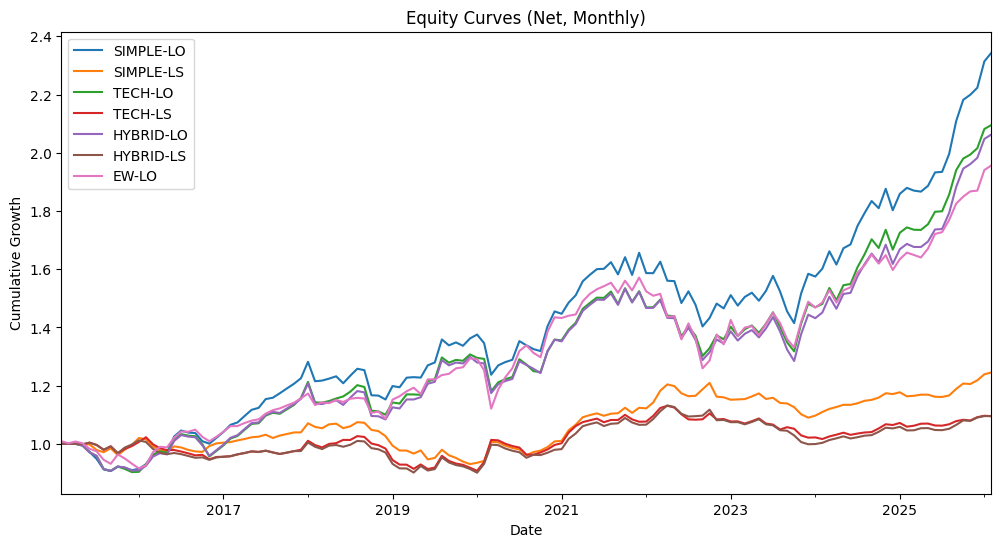

In [14]:
import matplotlib.pyplot as plt

eq = pd.DataFrame({k: (1 + v.returns_net).cumprod() for k, v in results.items()}).dropna(how="all")
ax = eq.plot(figsize=(12, 6))
ax.set_title("Equity Curves (Net, Monthly)")
ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Growth")
plt.show()

In [15]:
diag = pd.concat({k: v.diag for k, v in results.items()}, axis=1)
diag.tail()

SIMPLE-LO                             SIMPLE-LS                 \
                turnover gross_exposure net_exposure  turnover gross_exposure   
rebalance_date                                                                  
2025-09-30      0.086046       1.477857     1.477857  0.077956            1.5   
2025-10-31      0.254814       1.257311     1.257311  0.224110            1.5   
2025-11-30      0.107129       1.190772     1.190772  0.070755            1.5   
2025-12-31      0.058408       1.212746     1.212746  0.055451            1.5   
2026-01-31      0.121304       1.297625     1.297625  0.126469            1.5   

                               TECH-LO                               TECH-LS  \
                net_exposure  turnover gross_exposure net_exposure  turnover   
rebalance_date                                                                 
2025-09-30     -6.245005e-17  0.764586       1.500000     1.500000  0.743862   
2025-10-31      1.179612e-16  1.280771       1.257311     1.257311  1.108364   
2025-11-30     -7.632783e-17  0.107129       1.190772     1.190772  0.070755   
2025-12-31      9.020562e-17  0.777813       1.500000     1.500000  0.949493   
2026-01-31     -5.551115e-17  0.431964       1.500000     1.500000  0.376228   

                ...               HYBRID-LO                              \
                ...  net_exposure  turnover gross_exposure net_exposure   
rebalance_date  ...                                                       
2025-09-30      ... -2.775558e-17  1.325776       1.477857     1.477857   
2025-10-31      ... -3.469447e-17  0.254814       1.257311     1.257311   
2025-11-30      ...  8.326673e-17  0.107129       1.190772     1.190772   
2025-12-31      ... -1.387779e-17  0.777813       1.500000     1.500000   
2026-01-31      ... -8.326673e-17  0.979278       1.392237     1.392237   

               HYBRID-LS                                 EW-LO                 \
                turnover gross_exposure  net_exposure turnover gross_exposure   
rebalance_date                                                                  
2025-09-30      1.174304            1.5 -6.245005e-17      0.0            1.0   
2025-10-31      0.224110            1.5  2.775558e-17      0.0            1.0   
2025-11-30      0.070755            1.5  8.326673e-17      0.0            1.0   
2025-12-31      0.949493            1.5 -1.387779e-17      0.0            1.0   
2026-01-31      1.022308            1.5  0.000000e+00      0.0            1.0   

                             
               net_exposure  
rebalance_date               
2025-09-30              1.0  
2025-10-31              1.0  
2025-11-30              1.0  
2025-12-31              1.0  
2026-01-31              1.0  

[5 rows x 21 columns]